By Gabriel Jonathan (gabejonathan29@gmail.com) and Indriana Marcela (marcela.indriana@gmail.com)


In [1]:
# Essential packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from time import time
from scipy.signal import find_peaks
from scipy.optimize import fsolve, newton
from math import pi
import seaborn as sns

In [178]:
def phase_portrait_2D(params, dxdt, dydt, inits, fix_pts =  [], arrow_points = 25, xylab = ['x', 'y'], lw = 3, quad = True, show_plot = True):
    """ 

    Generates a 2-dimensional phase portrait for a particular linear 
    differential system with customary initial points and trajectory time.
    ...

    Parameters
    ----------
    params : array/list
        an array filled with required parameters for the phase portrait
        params = [Lx, Ly, plt_title]

    dxdt, dydt : function, handles
        the function describing the linear system as X'=AX=(dxdt, dydt)^T

    inits : array 
        array consisting of coordinates of initial points together with the given time for 
        trajectory
        inits  = [[x1, y1, t1],
                  [x2, y2, t2],]
                  ...
                  [xn, yn, tn]]
    

    fix_pts : array (optional)
        array consisting of fixed points

    arrow_points : int (optional, default = 25)
        defining the number of points on the grid where the arrow will be generated

    xylab : array (optional, default = ['x', 'y'])
        defining the x and y axis labels
        
    lw : float (optional, default = 3)
        defining the linewidth of the chosen trajectories in the phase portrait

    quad : int (optional, default = True)
        showing all quadrants if True
        otherwise, only showing the first quadrant (x>=0, y>=0)
    
    show_plot : bool (optional, default = True)
        showing the plots.
        otherwise, return the normalized arrow and trajectories

    """
    Lx, Ly = params[0], params[1]
    if quad :
        [Xa, Xb] = [-Lx, Lx]
        [Ya, Yb] = [-Ly, Ly]
    else :
        [Xa, Xb] = [0, Lx]
        [Ya, Yb] = [0, Ly]
    X = np.linspace(Xa, Xb, arrow_points)
    Y = np.linspace(Ya, Yb, arrow_points)
    X, Y = np.meshgrid(X, Y)

    def model(U,t):
        """
        Defining a function as an input for the odeint.
        """
        X, Y = U
        return [dxdt(X, Y), dydt(X, Y)]
    def cpoint(Z0,T):
        """
        Function to generate a unique trajectory given the initial points and the time
        
        Inputs
        ------
        Z0 : array
            coordinate of an initial points
        T : int
            time elapsed of the trajectory given the initial point
        """
        tspan = np.linspace(0, T, 300)
        ys = odeint(model, Z0, tspan)
        plt.plot(ys[:, 0], ys[:, 1], linewidth = lw , c = 'r')

    # Plotting
    if show_plot:
        sns.set(style='white')
        plt.rcParams['figure.dpi'] = 150
        # Normalizing the dxdt(X, Y), dydt(X, Y)
        u = dxdt(X, Y) 
        v = dydt(X, Y)
        r = np.power(np.add(np.power(u, 2), np.power(v, 2)), 0.5) + 1e-6
        plt.quiver(X, Y, u/r, v/r, alpha = 0.75)
        plt.xlabel(xylab[0])
        plt.ylabel(xylab[1])
        for x0y0t in inits:
            cpoint(x0y0t[:2], x0y0t[2])
        plt.xlim([Xa, Xb])
        plt.ylim([Ya, Yb])
        plt.axvline(x = 0, c = 'k')
        plt.axhline(y = 0, c = 'k')
        plt.title(params[2], fontweight = "bold", fontsize = 12.5)
        if len(fix_pts) > 0:
            plt.scatter([x[0] for x in fix_pts], [x[1] for x in fix_pts], c = 'k', s = 80)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    else:
        u = dxdt(X, Y) 
        v = dydt(X, Y)
        r = np.power(np.add(np.power(u, 2), np.power(v, 2)), 0.5) + 1e-6
        
        n_parts = 500
        n_init = len(inits)
        trajs_x = np.zeros((n_parts, n_init))
        trajs_y = np.zeros((n_parts, n_init))
        for i in range(n_init):
            x0y0t = inits[i]
            Z0 = x0y0t[:2]
            T = x0y0t[2]
            tspan = np.linspace(0, T, n_parts)
            ys = odeint(model, Z0, tspan)
            trajs_x[:, i] = ys[:, 0]
            trajs_y[:, i] = ys[:, 1]


        return [X, Y, u/r, v/r, trajs_x, trajs_y]


In [3]:
def RK4system(fs, y0, dom, h):
    '''
    RK4system produces an approximate solution to the following ODEs system:
        dy_i/dt = f_i([t, y_1, y_2, ..., y_k])
    for i = 1 .. k on the t domain of [a, b] satisfying initial conditions of y_i(a)=y0_i
    
    ...

    Parameters
    ----------
    fs  : callable
        RHS of the ODEs system, returning [f_1, f_2, .., f_k] with each f_i = f_i([t, y_1, .., y_k]).
    y0  : list
        Initial state of the system, y_j(a) = y0_j = y0[j]
    dom : list
        Domain of the system, dom = [a, b]
    h   : float
        Timestep, length of subintervals on the [a, b] partition.

    Returns
    -------
    array 
        An array with the form of 
            [[a = t_0, t_1,      t_2,    ..., t_n = b],
             [(y_1)_0, (y_1)_1, (y_1)_2, ..., (y_1)_n],
             [(y_2)_0, (y_2)_1, (y_2)_2, ..., (y_2)_n],
             ...
             [(y_k)_0, (y_k)_1, (y_k)_2, ..., (y_k)_n]]
        as the approximate solution to the ODEs.
    
    '''
    [a, b] = dom
    n = int((b - a) / h)     # Number of subintervals on the partition
    t = np.linspace(a, b, n + 1) # The array of points.
    k = len(fs()) # Number of function(s)

    y0 = np.array(y0)
    out = np.zeros([k + 1, n + 1])
    out[0, :] = t
    out[1:, 0] = y0
    funcs = fs()
    sol_i = y0
    for i in range(1, n + 1):
        # K1
        K1 = np.array([])
        inp1 = np.append(t[i-1], sol_i)
        for j in range(k):
            K1 = np.append(K1, h * funcs[j](inp1))
        # K2
        K2 = np.array([])
        for j in range(k):
            K2 = np.append(K2, h * funcs[j](inp1 + np.append([h], K1) / 2))
        # K3
        K3 = np.array([])
        for j in range(k):
            K3 = np.append(K3, h * funcs[j](inp1 + np.append([h], K2) / 2))
        # K4
        K4 = np.array([])
        for j in range(k):
            K4 = np.append(K4, h * funcs[j](inp1 + np.append([h], K3) ))
        sol_i = sol_i + (K1 + 2*K2 + 2*K3 + K4) / 6
        out[1:, i] = sol_i
    return out

In [4]:
def limit_cycle_scaling(funcs, inits, initT, dz):
    '''
    Producing limit cycles of a given system by scaling method.

    ...

    Parameters
    ----------
    dz  : float
        step on z domain
    
    funcs = [dx_dt, dy_dt]    : array of handles
        function describing the ODEs system
    
    inits = [initx, inity]  : array of handles
        function describing the system's initial state

    Returns
    -------
    x, y    : array
        the limit cycle curve
    T   : float
        the approximate period

    '''
    dx_dt, dy_dt = funcs
    initx, inity = inits
    z = np.arange(0, 1, dz).reshape(-1,1)
    N = len(z)
    vector_field = lambda U : [dx_dt(U[0], U[1]), dy_dt(U[0], U[1])]
    Ueq = fsolve(vector_field, (1,1))
    # Initial Guess
    x0 = initx(z) + Ueq[0]
    y0 = inity(z) + Ueq[1]
    T0 = initT
    U0 = np.concatenate((np.concatenate((x0,y0)), np.ones((1,1))*T0))
    def limit_cycle(U0, dz, N):
        x = U0[:N]
        y = U0[N:2*N]
        T = U0[2*N]
        xdot = (np.append(x[1:], x[0]) - np.append(x[N-1], x[:N-1])) / (2*dz)
        ydot = (np.append(y[1:], y[0]) - np.append(y[N-1], y[:N-1])) / (2*dz)
        F1 = xdot/T - dx_dt(x, y)
        F2 = ydot/T - dy_dt(x, y)
        F3 = abs(x[0] - Ueq[0])
        return np.append(np.append(F1.reshape(1,-1), F2.reshape(1,-1)), np.ones((1,1))*F3)
    
    sol_U = fsolve(lambda U : limit_cycle(U, dz, N), U0)
    x = sol_U[:N]
    y = sol_U[N:2*N]
    T = sol_U[2*N]

    return x, y, T

# 1. Isoclines for fixed points

C:\Users\GABRIELJ\AppData\Local\Temp\ipykernel_23840\1121620649.py:5: RuntimeWarning: invalid value encountered in log
  S_inv = lambda b, theta, y : theta - np.log((np.exp(b*theta)*(1 - y) - y) / (1 + y*(1 + np.exp(b*theta))))/b


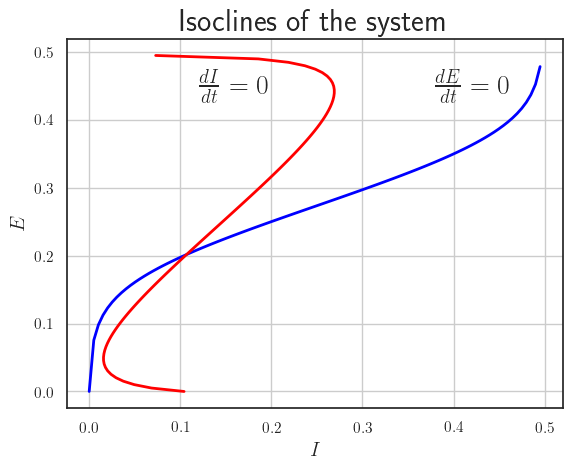

In [235]:
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
# Firing rate (S) and its inverse (S_inv)
S = lambda b, theta, x : 1/(1 + np.exp(-b*(x - theta))) - 1/(1 + np.exp(b*theta))
S_inv = lambda b, theta, y : theta - np.log((np.exp(b*theta)*(1 - y) - y) / (1 + y*(1 + np.exp(b*theta))))/b

# Parameters
theta_e, theta_i = 4, 3.7
b_e, b_i = 1.3, 2
r_e, r_i = 1, 1
c_1 = 16
c_2 = 12
c_3 = 15
c_4 = 3
P = 1.25
Q = 0
k_e = S(b_e, theta_e, np.infty)
k_i = S(b_i, theta_i, np.infty)

I_iso = lambda E : (c_1*E - S_inv(b_e, theta_e, E/(k_e - r_e*E)) + P)/c_2
E_iso = lambda I : (c_4*I + S_inv(b_i, theta_i, I/(k_i - r_i*I)) - Q)/c_3
Is = np.linspace(0, 0.5, 100)
Es = np.linspace(0, 0.5, 100)
plt.plot(Is, E_iso(Is), linewidth = 2, color = 'blue')
plt.plot(I_iso(Es), Es, linewidth = 2, color = 'red')
plt.xlabel(r"$I$", fontsize = 15)
plt.ylabel(r"$E$", fontsize = 15)
plt.text(0.38, 0.44, r"$\frac{dE}{dt}=0$", fontsize = 20)
plt.text(0.12, 0.44, r"$\frac{dI}{dt}=0$", fontsize = 20)
plt.title(r"Isoclines of the system", fontsize = 22)
plt.grid(True)

In [34]:
fixed_pts_funcs_E = lambda E : E - (c_4*I_iso(E) + S_inv(b_i, theta_i, I_iso(E) / (k_i - r_i*I_iso(E))) - Q)/c_3
E_fixed = fsolve(fixed_pts_funcs_E, 0.2)[0]
I_fixed = I_iso(E_fixed)
print('Fixed point of the system : (I*, E*) = ({:.3f}, {:.3f})'.format(I_fixed, E_fixed))

Fixed point of the system : (I*, E*) = (0.107, 0.202)


In [263]:
# Jacobian of the system
S_m_prime = lambda b_m, theta_m, x : b_m * np.exp(b_m*(x - theta_m)) / (np.exp(b_m*(x - theta_m)) + 1)**2
f_I = c_2*(r_e*E_fixed - k_e)*S_m_prime(b_e, theta_e, c_1*E_fixed - c_2*I_fixed + P)
f_E = -1 - r_e*S(b_e, theta_e, c_1*E_fixed - c_2*I_fixed + P) + c_1*(k_e - r_e*E_fixed)*S_m_prime(b_e, theta_e, c_1*E_fixed - c_2*I_fixed + P)
g_I = -1 - r_i*S(b_i, theta_i, c_3*E_fixed - c_4*I_fixed + Q) - c_4*(k_i - r_i*I_fixed)*S_m_prime(b_i, theta_i, c_3*E_fixed - c_4*I_fixed + Q)
g_E = c_3*(k_i - r_i*I_fixed)*S_m_prime(b_i, theta_i, c_3*E_fixed - c_4*I_fixed + Q)
J1 = np.array([[f_I, f_E], [g_I, g_E]])
print("Jacobian : \n", J1)

eig_vals, eig_vecs = np.linalg.eig(J1)
print("Eigenvalues : \n", eig_vals)
print("Eigenvectors : \n", eig_vecs)

Jacobian : 
 [[-1.91972177  1.37296653]
 [-1.68677703  2.8350649 ]]
Eigenvalues : 
 [-1.36883074  2.28417387]
Eigenvectors : 
 [[-0.92807887 -0.31045612]
 [-0.37238368 -0.95058771]]


# 2. Limit Cycle

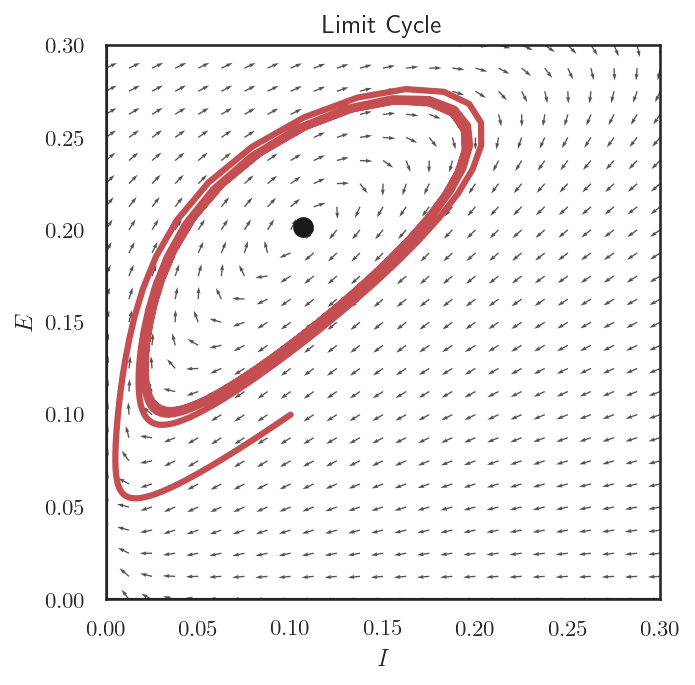

In [36]:
dIdt = lambda I, E : -I + (k_i - r_i*I)*S(b_i, theta_i, c_3*E - c_4*I + Q)
dEdt = lambda I, E : -E + (k_e - r_e*E)*S(b_e, theta_e, c_1*E - c_2*I + P)
funcs = [dIdt, dEdt]
inits = [[0.1, 0.1, 30]]
params_1 = [0.3, 0.3, "Limit Cycle"]
phase_portrait_2D(params_1, dIdt, dEdt, inits, fix_pts = [[I_fixed, E_fixed]], xylab = ['$I$', '$E$'], quad = False)

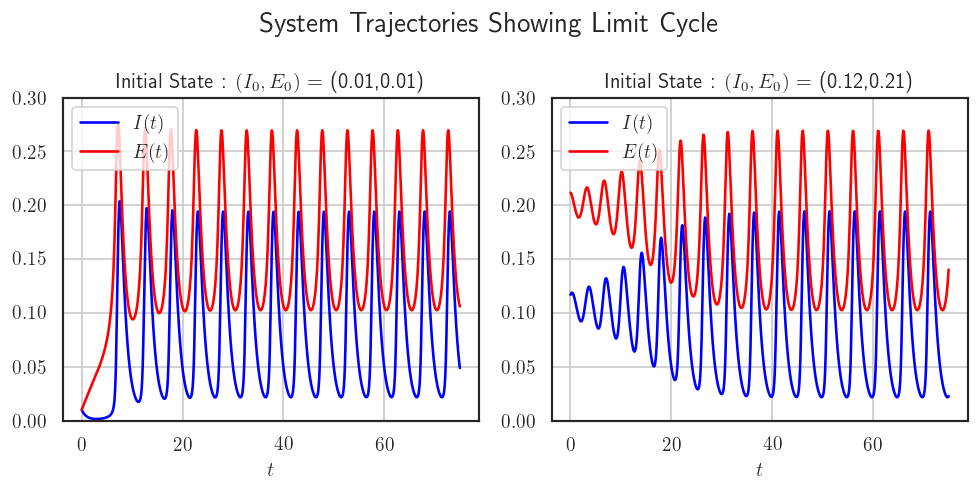

In [49]:
# Plotting the trajectories to further portray the limit cycle.
def func_sys():
    # U = [t, I, E]
    I_dot = lambda U : -U[1] + (k_i - r_i*U[1])*S(b_i, theta_i, c_3*U[2] - c_4*U[1] + Q)
    E_dot = lambda U : -U[2] + (k_e - r_e*U[2])*S(b_e, theta_e, c_1*U[2] - c_2*U[1] + P)
    return [I_dot, E_dot]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8, 4))
# Initial points #1, (0.01, 0.01)
traj_1 = RK4system(func_sys, [0.01, 0.01], [0, 75], 0.1)
ax[0].plot(traj_1[0, :], traj_1[1, :], color = 'blue')
ax[0].plot(traj_1[0, :], traj_1[2, :], color = 'red')
ax[0].set(xlabel = r'$t$', title = r"Initial State : $(I_0, E_0)$ = (" + str(0.01) + "," + str(0.01) + ")")
ax[0].set_ybound(0, 0.3)
ax[0].grid(True)
ax[0].legend([r'$I(t)$', r'$E(t)$'])

traj_2 = RK4system(func_sys, [I_fixed+0.01, E_fixed+0.01], [0, 75], 0.1)
ax[1].plot(traj_2[0, :], traj_2[1, :], color = 'blue')
ax[1].plot(traj_2[0, :], traj_2[2, :], color = 'red')
ax[1].set(xlabel = r'$t$', title = r"Initial State : $(I_0, E_0)$ = (" + "{:.2f}".format(I_fixed+0.01) + "," + "{:.2f}".format(E_fixed+0.01) + ")")
ax[1].set_ybound(0, 0.3)
ax[1].grid(True)
ax[1].legend([r'$I(t)$', r'$E(t)$'])


fig.suptitle(r"System Trajectories Showing Limit Cycle", fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

c:\Users\GABRIELJ\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


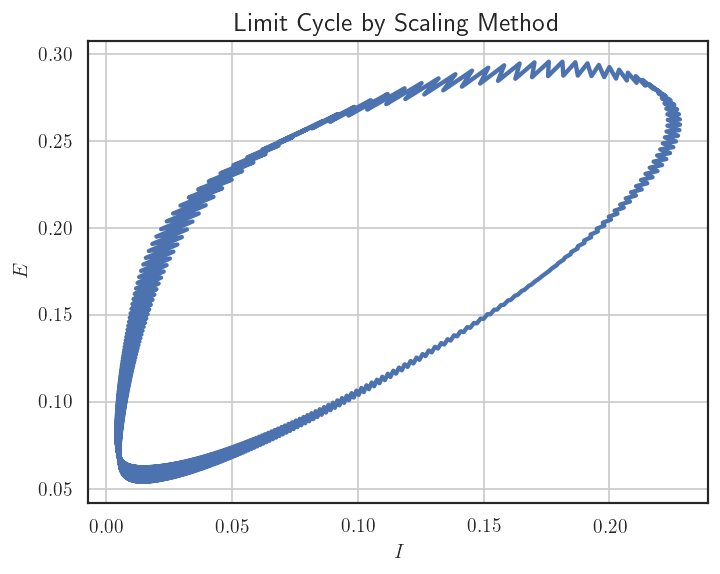

Periode : 8.127 s


In [48]:
init1 = [lambda z : 0.3*np.sin(2*pi*z), lambda z : 2*pi*0.3*np.cos(2*pi*z)]
I_1, E_1, t_1 = limit_cycle_scaling([dIdt, dEdt], init1, 7, 0.00125)
sns.set(style='white')
plt.rcParams['figure.dpi'] = 125
plt.title("Limit Cycle by Scaling Method", fontweight="bold", fontsize=15)
plt.plot(I_1, E_1, linewidth = 2.5)
plt.grid(True)
plt.xlabel(r'$I$')
plt.ylabel(r'$E$')
plt.show()
print("Periode : {:.3f} s".format(t_1))

# 3. Bifurcation

In [180]:
# Showing the evolution of the phase portrait as the P changes
def dEdt_bif(P_params):
    return lambda I, E : -E + (k_e - r_e*E)*S(b_e, theta_e, c_1*E - c_2*I + P_params)

def pp_bifurc(P, inits):
    params_bif = [0.5, 0.5, ""]
    return phase_portrait_2D(params_bif, dIdt, dEdt_bif(P), inits, fix_pts = [[I_fixed, E_fixed]], xylab = ['$I$', '$E$'], quad = False, show_plot = False)


I1, E1, u1, v1, trajs_1_x, trajs_1_y = pp_bifurc(0.5, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
I2, E2, u2, v2, trajs_2_x, trajs_2_y = pp_bifurc(0.75, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
I3, E3, u3, v3, trajs_3_x, trajs_3_y = pp_bifurc(1, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
I4, E4, u4, v4, trajs_4_x, trajs_4_y = pp_bifurc(1.25, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
I5, E5, u5, v5, trajs_5_x, trajs_5_y = pp_bifurc(1.5, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
I6, E6, u6, v6, trajs_6_x, trajs_6_y = pp_bifurc(2, [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])

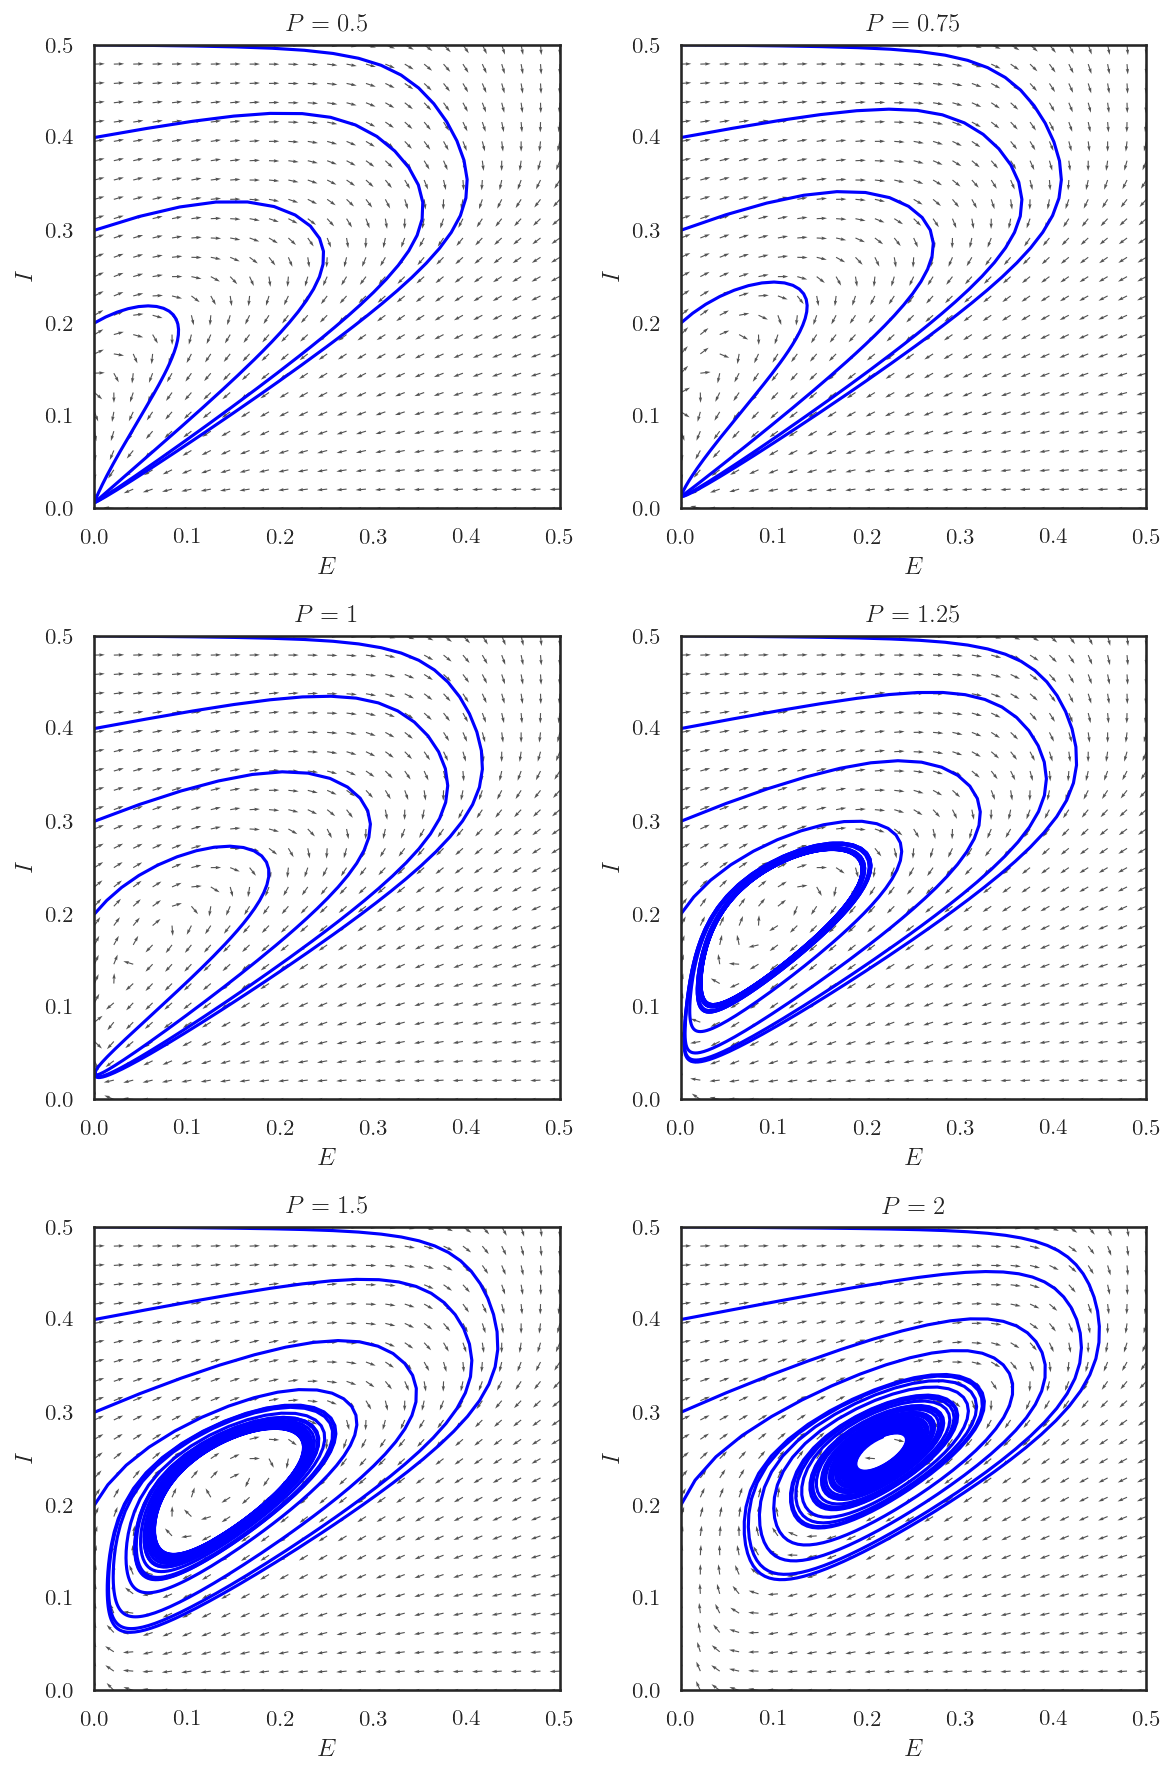

In [181]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (8, 12))


ax[0, 0].quiver(I1, E1, u1, v1, alpha = 0.75)
ax[0, 0].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=0.5$")
for i in range(np.shape(trajs_1_x)[1]):
    ax[0, 0].plot(trajs_1_x[:, i], trajs_1_y[:, i], color = 'blue')

ax[0, 1].quiver(I2, E2, u2, v2, alpha = 0.75)
ax[0, 1].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=0.75$")
for i in range(np.shape(trajs_2_x)[1]):
    ax[0, 1].plot(trajs_2_x[:, i], trajs_2_y[:, i], color = 'blue')

ax[1, 0].quiver(I3, E3, u3, v3, alpha = 0.75)
ax[1, 0].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=1$")
for i in range(np.shape(trajs_3_x)[1]):
    ax[1, 0].plot(trajs_3_x[:, i], trajs_3_y[:, i], color = 'blue')

ax[1, 1].quiver(I4, E4, u4, v4, alpha = 0.75)
ax[1, 1].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=1.25$")
for i in range(np.shape(trajs_4_x)[1]):
    ax[1, 1].plot(trajs_4_x[:, i], trajs_4_y[:, i], color = 'blue')

ax[2, 0].quiver(I5, E5, u5, v5, alpha = 0.75)
ax[2, 0].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=1.5$")
for i in range(np.shape(trajs_5_x)[1]):
    ax[2, 0].plot(trajs_5_x[:, i], trajs_5_y[:, i], color = 'blue')

ax[2, 1].quiver(I6, E6, u6, v6, alpha = 0.75)
ax[2, 1].set(xlabel = r"$E$", ylabel = r"$I$", title = r"$P=2$")
for i in range(np.shape(trajs_6_x)[1]):
    ax[2, 1].plot(trajs_6_x[:, i], trajs_6_y[:, i], color = 'blue')
for i in range(3):
    for j in range(2):
        ax[i, j].set_ybound(0, 0.5)
        ax[i, j].set_xbound(0, 0.5)

plt.tight_layout()
    

## Steady-State Diagram, using Pseudo-Arclength Continuation

In [200]:
import numpy as np
def NR_system(funcs, J, inits, maxiter = 1000, Tol = 1e-8):
    '''
    Finding the solution of a system of equations, with the Jacobian matrix J
    Parameters
    ----------

    funcs : array of callables
        funcs = [f_1, f_2, .., f_m] with each f_i = f_i([x_1, .., x_n]).
    
    J : array of callables
        J = [df_i(x)/dx_j], i = 1, ..., m,  j = 1, 2, ..., n
        size  : (m, n)

    inits : array
        initial guess.

    maxiter : integers
        maximum number of iterations allowed. 

    Tol : float
        tolerance for stopping criteria.

    Returns 
    -------
    array, approximation to the solution of funcs = 0

    '''

    x_k = np.array(inits)
    iter = 0
    while iter < maxiter:
        J_k = np.array(J(x_k))
        if abs(np.linalg.det(J_k)) < 1e-6:
            print("Singularities detected. Iteration failed.")
            return np.nan
        funcs_k = np.array(funcs(x_k))
        s_k = np.linalg.solve(J_k, -funcs_k)
        x_k1 = x_k + s_k
        funcs_k1 = np.array(funcs(x_k1))
        if abs(funcs_k1).all() < Tol:
            return x_k1
        
        x_k = x_k1
        iter += 1
    
    print("Maximum number of iteration attained.")
    return x_k

In [413]:
# Parameters
theta_e, theta_i = 2.8, 4
b_e, b_i = 1.2, 1
r_e, r_i = 1, 1
c_1 = 12
c_2 = 4
c_3 = 13
c_4 = 11
Q = 0
# Find (I0, E0, P0) by setting the P0 = -0.35 then calculate I0, E0 by NR_system
P0 = -0.5
def F_NR(U):
    # U = [I, E]
    return [-U[0] + (k_i - r_i*U[0])*S(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q), -U[1] + (k_e - r_e*U[1])*S(b_e, theta_e, c_1*U[1] - c_2*U[0] + P0)]
def J_NR(U):
    # U = [I, E]
    gI = -1-r_i*S(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)-c_4*(k_i-r_i*U[0])*S_m_prime(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)
    gE = c_3*(k_i - r_i*U[0])*S_m_prime(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)
    fI = c_2*(r_e*U[1] - k_e)*S_m_prime(b_e, theta_e, c_1*U[1] - c_2*U[0] + P0)
    fE = -1-r_e*S(b_e, theta_e, c_1*U[1] - c_2*U[0] + P0)+c_1*(k_e-r_e*U[1])*S_m_prime(b_e, theta_e, c_1*U[1] - c_2*U[0] + P0)
    return [[gI, gE], [fI, fE]]
I0, E0 = NR_system(F_NR, J_NR, [0.02, 0.02])
print('Initial starting parameters for P0 = {:.3f} : (I0, E0) = ({:.5f}, {:.5f})'.format(P0, I0, E0))
print(F_NR([I0, E0]))


Initial starting parameters for P0 = -0.500 : (I0, E0) = (-0.00343, -0.01939)
[2.168404344971009e-18, 0.0]


In [460]:
# Pseudo-Arclength Continuation 
def F_PAC(P_par):
    # U = [I, E]
    return lambda U : np.array([[-U[0] + (k_i - r_i*U[0])*S(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)], [-U[1] + (k_e - r_e*U[1])*S(b_e, theta_e, c_1*U[1] - c_2*U[0] + P_par)]])
def J_PAC(P_par):
    # U = [I, E]
    def out(U): 
        gI = -1-r_i*S(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)-c_4*(k_i-r_i*U[0])*S_m_prime(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)
        gE = c_3*(k_i - r_i*U[0])*S_m_prime(b_i, theta_i, c_3*U[1] - c_4*U[0] + Q)
        fI = c_2*(r_e*U[1] - k_e)*S_m_prime(b_e, theta_e, c_1*U[1] - c_2*U[0] + P_par)
        fE = -1-r_e*S(b_e, theta_e, c_1*U[1] - c_2*U[0] + P_par)+c_1*(k_e-r_e*U[1])*S_m_prime(b_e, theta_e, c_1*U[1] - c_2*U[0] + P_par)
        return np.array([[gI, gE], [fI, fE]])
    return out
def F_PAC_par(P_par):
    # U = [I, E]
    return lambda U : [[0], [S_m_prime(b_e, theta_e, c_1*U[1] - c_2*U[0] + P_par)]]
def check_stability(M):
    eigvalues = np.linalg.eigvals(M)
    reals = np.real(eigvalues)
    if np.all(reals < 0):
        return True # Stable
    else:
        return False
sk = 0 # Current arclength
ds = 0.005 # Arclength step
X0 = np.array([I0, E0]) # Parameters
Xk = X0
Pk = P0
Xprev = Xk
Pprev = Pk
# To store Ik, Ek, Pk values.
Ik_arr_stable = []
Ik_arr_stable_2 = []
Ik_arr_unstable = []
Ek_arr_stable = []
Ek_arr_stable_2 = []
Ek_arr_unstable = []
Pk_arr_stable = []
Pk_arr_stable_2 = []
Pk_arr_unstable = []

# Counter
k = 1
trans = False
while sk < 5:
    # Calculate the z.
    Fk = F_PAC(Pk)
    Jk = J_PAC(Pk)
    F_par = F_PAC_par(Pk)
    Fxk = np.array(Jk(Xk))
    FPk = np.array(F_par(Xk))
    z = np.linalg.solve(Fxk, -FPk)
    tau = np.append(z, 1).reshape(-1, 1) / np.sqrt(np.sum(z*z) + 1)
    if sk > 0 :
        if np.sum(tau*tau_prev) < 0:
            tau = -tau
    tau_prev = tau
    sk = sk + ds
    tauxk = tau[:-1].reshape(1, -1)
    tauPk = tau[-1].reshape(1, -1)
    LHS_top = np.append(Fxk, FPk.reshape(2, 1), axis = 1)
    LHS_low = np.append(tauxk, tauPk, axis = 1)
    LHS = np.append(LHS_top, LHS_low, axis = 0)
    RHS = np.append(Fk(Xk), np.sum(tauxk*(Xk - Xprev))+tauPk*(Pk - Pprev)-ds)
    Xprev = Xk
    Pprev = Pk
    deltas = np.linalg.solve(LHS, -RHS)
    Xk = Xk + deltas[:2]
    Pk = Pk + deltas[-1]
    if check_stability(J_PAC(Pk)(Xk)) and not trans:
        Ik_arr_stable = np.append(Ik_arr_stable, Xk[0])
        Ek_arr_stable = np.append(Ek_arr_stable, Xk[1])
        Pk_arr_stable = np.append(Pk_arr_stable, Pk)
    elif check_stability(J_PAC(Pk)(Xk)) and trans:
        Ik_arr_stable_2 = np.append(Ik_arr_stable_2, Xk[0])
        Ek_arr_stable_2 = np.append(Ek_arr_stable_2, Xk[1])
        Pk_arr_stable_2 = np.append(Pk_arr_stable_2, Pk)
    elif not check_stability(J_PAC(Pk)(Xk)):
        Ik_arr_unstable = np.append(Ik_arr_unstable, Xk[0])
        Ek_arr_unstable = np.append(Ek_arr_unstable, Xk[1])
        Pk_arr_unstable = np.append(Pk_arr_unstable, Pk)
        trans = True
    k += 1

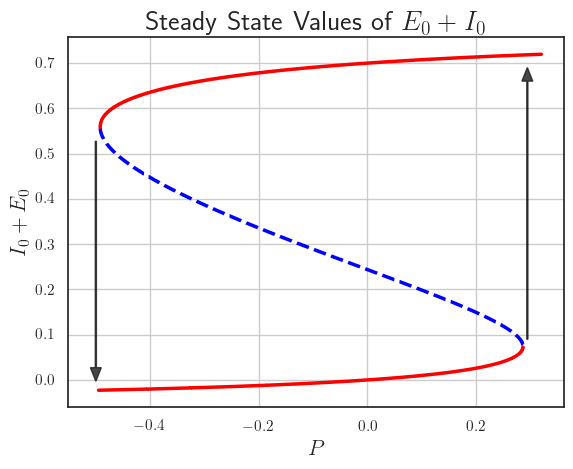

In [506]:
plt.plot(Pk_arr_unstable, Ik_arr_unstable + Ek_arr_unstable, color = 'blue', linestyle = 'dashed', linewidth = 2.5)
plt.plot(Pk_arr_stable, (Ik_arr_stable + Ek_arr_stable), color = 'red', linewidth = 2.5)
plt.plot(Pk_arr_stable_2, (Ik_arr_stable_2 + Ek_arr_stable_2), color = 'red', linewidth = 2.5)
plt.arrow(P0, I0+E0+0.55, 0, -0.5, width = 0.002, head_width = 0.02, ec = 'k', fc = 'k', alpha = 0.8)
plt.arrow(0.295, 0.09, 0, 0.57, width = 0.002, head_width = 0.02, ec = 'k', fc = 'k', alpha = 0.8)
plt.grid(True)
plt.ylabel(r"$I_0+E_0$", fontsize = 16)
plt.xlabel(r"$P$", fontsize = 16)
plt.title(r"Steady State Values of $E_0+I_0$", fontsize = 20)

plt.show()

# 4. Animation

In [199]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


# Varying parameters
P_s = np.linspace(-0.5, 3.5, 90)
# Plotting isoclines
E_iso = lambda I : (c_4*I + S_inv(b_i, theta_i, I/(k_i - r_i*I)) - Q)/c_3
def I_iso_P_s(P_params):
    return lambda E : (c_1*E - S_inv(b_e, theta_e, E/(k_e - r_e*E)) + P_params)/c_2

fig, ax = plt.subplots(1, 1)
def animate(i):
    ax.clear()
    # Isoclines
    inp = np.linspace(-0.01, 0.501, 100)
    E_iso_pts = E_iso(inp)
    I_iso_pts = I_iso_P_s(P_s[i])(inp)
    ax.plot(inp, E_iso_pts, linestyle = 'dashed', color = 'black')
    ax.plot(I_iso_pts, inp, linestyle = 'dashed', color = 'black')
    # PP
    I, E, u, v, trajs_x, trajs_y = pp_bifurc(P_s[i], [[0, 0.2, 30], [0, 0.3, 30], [0, 0.4, 30], [0, 0.5, 30]])
    ax.quiver(I, E, u, v, alpha = 0.75)
    ax.set(xlabel = r"$I$", ylabel = r"$E$")
    ax.set_title(r"$P={:.2f}$".format(P_s[i]), fontsize = 22)
    for i in range(np.shape(trajs_x)[1]):
        ax.plot(trajs_x[:, i], trajs_y[:, i], color = 'blue')
    ax.set_xlim([0, 0.5])
    ax.set_ylim([0, 0.5])

ani = FuncAnimation(fig, animate, frames=len(P_s), interval=500, repeat=True)
ani.save("phase_portrait_animation.gif", dpi=300, writer=PillowWriter(fps=15))
plt.close()


C:\Users\GABRIELJ\AppData\Local\Temp\ipykernel_23840\1121620649.py:5: RuntimeWarning: invalid value encountered in log
  S_inv = lambda b, theta, y : theta - np.log((np.exp(b*theta)*(1 - y) - y) / (1 + y*(1 + np.exp(b*theta))))/b
